# Word embeddings with Python

*This activity has been inspired from the [Word embeddings demo](https://gist.github.com/fgiobergia/b3a20e097f9b697d0a02fb17685cfd5a) by Flavio Giobergia*

## Setup

Please check you have configured your environment properly with uv (see [setup](../setup.md))

## Load required libraries

In this example, we will use the `gensim` library to manipulate word embeddings. 

In [1]:
import gensim.downloader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Load the model

We will use a [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) model, which is a pre-trained word embedding model developed by researchers at Stanford University. It is designed to capture the meaning of words based on their co-occurrence patterns in large corpora of text. GloVe is a count-based model only, not based on neural networks (transformers). It is however sufficiently robust to get you started with word embeddings and to understand the basic concepts behind them.

More precisely, we will use the `glove-wiki-gigaword-100` model which is a smaller version of the GloVe model trained on Wikipedia and the Gigaword dataset. It contains 100-dimensional word vectors for 400,000 words.

Download on disk and load the model into memory. This may take a couple of minutes.

In [2]:
word_vectors = gensim.downloader.load("glove-wiki-gigaword-100")

## Explore the model and its vocabulary

Print the first 10 words in the vocabulary (words known by the model) and the vocabulary size:

In [3]:
print(f"Vocabulary size: {len(word_vectors.index_to_key):,}")
print("Ten first words:")
for word in word_vectors.index_to_key[:10]:
    print(word)

Vocabulary size: 400,000
Ten first words:
the
,
.
of
to
and
in
a
"
's


Here a *word* could be an usual word like `the`, `of`, `and`... but also punctuation marks like `,`, `.` or `"`.

In [4]:
# Let's define a function to display word vectors and their dimensions
def print_word_info(word: str) -> None:
    try:
        vector = word_vectors.get_vector(word)
        print(f"Vector for the '{word}': {vector[:5]}...")
        print(f"Vector length: {len(vector)}")
    except KeyError:
        print(f"'{word}' not found in vocabulary.")

Print first coordinates of vector and vector dimension for a couple of words:

In [5]:
print_word_info("simulation")
print_word_info("science")
print_word_info("bioinformatics")

Vector for the 'simulation': [-0.51781   0.069206 -0.092875  0.44081  -0.57836 ]...
Vector length: 100
Vector for the 'science': [-0.13322  0.48858  0.18867  0.33791  0.54542]...
Vector length: 100
Vector for the 'bioinformatics': [-0.68671  0.67934 -0.29225  0.38358  0.80295]...
Vector length: 100


Unfortunately, all words are not in the vocabulary. Unknown words are abbreviations and words in other languages than English.

In [6]:
print_word_info("LLM")
print_word_info("MD")
print_word_info("moléculaire")
print_word_info("modèle")

'LLM' not found in vocabulary.
'MD' not found in vocabulary.
'moléculaire' not found in vocabulary.
Vector for the 'modèle': [ 0.042508 -0.96815  -1.3283    0.61907   0.15938 ]...
Vector length: 100


## Find similar words

For a given word, the `similar_by_word()` method returns the most similar words in the vocabulary, together with their similarity score. Let's try with the word `simulation`:

In [7]:
word_vectors.similar_by_vector(word_vectors.get_vector("simulation"), topn=10)

[('simulation', 1.0),
 ('simulations', 0.8206844329833984),
 ('simulator', 0.7404708862304688),
 ('modeling', 0.7228801846504211),
 ('visualization', 0.7066413760185242),
 ('real-time', 0.6895408630371094),
 ('modelling', 0.6483812928199768),
 ('algorithms', 0.6401902437210083),
 ('computing', 0.6401691436767578),
 ('simulated', 0.6365459561347961)]

The word `simulation` is of course the closest to itself with a score of 1.0. Next closest words are `simulations`, `simulator`, `modeling`...

We can try with another example:

In [8]:
word_vectors.similar_by_vector(word_vectors.get_vector("learning"), topn=10)

[('learning', 1.0000001192092896),
 ('teaching', 0.7720069289207458),
 ('knowledge', 0.76064133644104),
 ('experience', 0.7378624081611633),
 ('skills', 0.734375),
 ('learn', 0.7340658903121948),
 ('understanding', 0.699902355670929),
 ('education', 0.6989467740058899),
 ('educational', 0.6864885687828064),
 ('lessons', 0.681064784526825)]

## Make mathematical operations on vectors

The avantage of vector representations is that they allow us to perform mathematical operations on words.

In [9]:
target = word_vectors.get_vector("king") - word_vectors.get_vector("man") + word_vectors.get_vector("woman")
word_vectors.similar_by_vector(target, topn=10)

[('king', 0.8551837205886841),
 ('queen', 0.783441424369812),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109855651855),
 ('daughter', 0.6809081435203552),
 ('prince', 0.6713141798973083),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325795173645),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392418742179871)]

Here is the famous equation :

*king - man + woman ~ queen*

(that is a very binary representation of the world...).

Note that *king* is the most similar word to the result of the operation. The word *queen* is the most similar word to the result of the operation that **does not appear in the operation itself**.

Try yourself to make the following operations:

*cucumber - vegetable + fruit*

In [10]:
# type your code here

And with:

*sushi - japan + germany*

In [11]:
# type your code here

## Semantical comparisons

In the following example, we will compare pairs of words related to a same concept. For instance, `norway` and `oslo`, and `france` and `paris`, are related to the concept of country and capital city.

With this model, words are represented as 100-dimensional vectors. These 100 dimensions make the visual representation of the words very difficult. We will use a dimensionality reduction technique called Principal Component Analysis (PCA) to reduce the dimensionality of the vectors to 2 dimensions, which will allow us to visualize the words in a 2D space.

In [12]:
countries = ["norway", "germany", "france", "italy", "greece", "portugal"]
capitals  = ["oslo", "berlin",  "paris",  "rome",  "athens", "lisbon"]

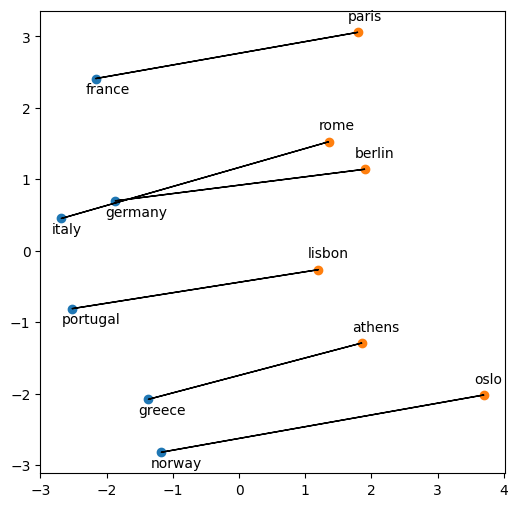

In [13]:
def plot_pairs(
    wv: gensim.models.keyedvectors.KeyedVectors, 
    word_list_1: list,
    word_list_2: list
    ):
    """Plot pairs of words in 2D space using PCA."""
    wv_all = [ wv.get_vector(word) for word in (word_list_1 + word_list_2) ]
    
    pca = PCA(2)
    wv_pca_all = pca.fit_transform(wv_all)
    
    wv_pca_1 = wv_pca_all[:len(word_list_1)]
    wv_pca_2 = wv_pca_all[len(word_list_2):]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(wv_pca_1[:,0], wv_pca_1[:,1])
    plt.scatter(wv_pca_2[:,0], wv_pca_2[:,1])
    
    for i, (word_1, word_2) in enumerate(zip(word_list_1, word_list_2)):
        plt.annotate(word_1, wv_pca_1[i], xytext=(-10,-15), textcoords="offset pixels")
        plt.annotate(word_2, wv_pca_2[i], xytext=(-10,12), textcoords="offset pixels")
        
    for i in range(len(wv_pca_1)):
        plt.arrow(wv_pca_1[i,0], wv_pca_1[i,1], wv_pca_2[i,0]-wv_pca_1[i,0], wv_pca_2[i,1]-wv_pca_1[i,1], shape="left")

plot_pairs(word_vectors, countries, capitals)

We observe that the vector between capital city and country is similar for all pairs of words, which means that the model has learned the relationship between countries and their capital cities.

A similar observation can be made for adjectives and their comparative forms, such as `big` and `bigger`, or `good` and `better`:

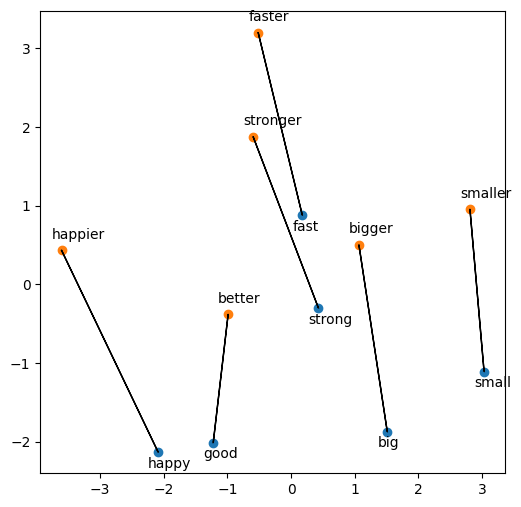

In [14]:
adjectives = ["small", "fast", "happy", "strong", "big", "good"]
comparatives = ["smaller", "faster", "happier", "stronger", "bigger", "better"]
plot_pairs(word_vectors, adjectives, comparatives)

Once again, this representations shows that the model has learned the relationship between adjectives and their comparative forms.

Eventually, we can perform a similar comparison with nouns and their singular and plural forms, such as `cat` and `cats`, or `child` and `children`:

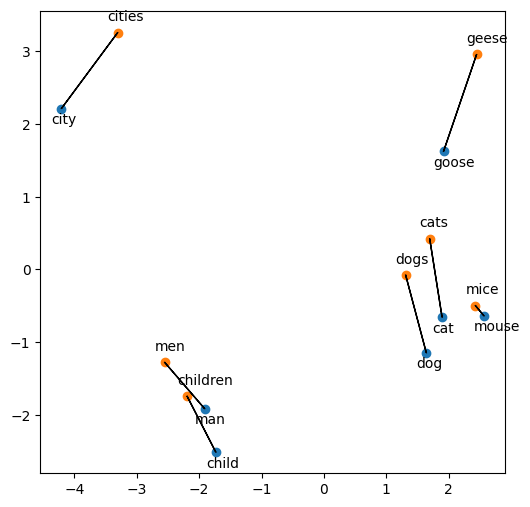

In [15]:
singular_nouns = ["cat", "dog", "child", "mouse", "city", "man", "goose"]
plural_nouns =   ["cats",  "dogs", "children",  "mice", "cities", "men", "geese"]
plot_pairs(word_vectors, singular_nouns, plural_nouns)

The model has learned the relationship between singular and plural forms. We can also observe that the model groups together nouns related to human beings such as `man` and `child`, animals such as `cat` and `dog` and non-living things suchs as `city`.
